In [13]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Darcy Flow discussed in Section 5.2 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utilities3 import *

from Adam import Adam
from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)


################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width, ln=True):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        
#         if ln:
#             self.bn0 = torch.nn.LayerNorm([width, s+self.padding, s+self.padding])
#             self.bn1 = torch.nn.LayerNorm([width, s+self.padding, s+self.padding])
#             self.bn2 = torch.nn.LayerNorm([width, s+self.padding, s+self.padding])
#             self.bn3 = torch.nn.LayerNorm([width, s+self.padding, s+self.padding])
            

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
#         x = self.bn0(x)
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
#         x = self.bn1(x)
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
#         x = self.bn2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
#         x = self.bn3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)
    
    
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self, device):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

In [18]:
################################################################
# configs
################################################################
device = torch.device('cuda:0')
TRAIN_PATH = 'data/piececonst_r421_N1024_smooth1.mat'
TEST_PATH = 'data/piececonst_r421_N1024_smooth2.mat'

ntrain = 1000
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 300
step_size = 100
gamma = 0.5

modes = 12
width = 32

r = 3
h = int(((421 - 1)/r) + 1)
s = h

################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)
x_train = reader.read_field('coeff')[:ntrain,::r,::r][:,:s,:s]
y_train = reader.read_field('sol')[:ntrain,::r,::r][:,:s,:s]

reader.load_file(TEST_PATH)
x_test = reader.read_field('coeff')[:ntest,::r,::r][:,:s,:s]
y_test = reader.read_field('sol')[:ntest,::r,::r][:,:s,:s]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)


# y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,s,s,1)
x_test = x_test.reshape(ntest,s,s,1)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train.to(device), y_train.to(device)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test.to(device), y_test.to(device)), batch_size=batch_size, shuffle=False)

In [27]:
################################################################
# training and evaluation
################################################################

def objective(modes, width, learning_rate):
    
    model = FNO2d(modes, modes, width).to(device)
    print(count_params(model))

    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
    #                        div_factor=1e4, 
    #                        final_div_factor=1e4,
    #                        pct_start=0.3,
    #                        steps_per_epoch=len(train_loader)*5, 
    #                        epochs=100)


    myloss = LpLoss(size_average=False)

    y_normalizer = UnitGaussianNormalizer(y_train)
    y_normalizer.cuda(device)

    train_l2_rec, test_l2_rec = [], []
    with tqdm(total=epochs) as pbar_ep:

        for epoch in range(epochs):
            model.train()
    #         t1 = default_timer()
            train_l2 = 0
            for x, y in train_loader:
                optimizer.zero_grad()
                out = model(x).reshape(batch_size, s, s)
                out = y_normalizer.decode(out)
        #         y = y_normalizer.decode(y)

                loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
                loss.backward()

                optimizer.step()
                train_l2 += loss.item()

            ############################
            lr = optimizer.param_groups[0]['lr']

            scheduler.step()

            model.eval()
            test_l2 = 0.0
            with torch.no_grad():
                for x, y in test_loader:
                    out = model(x).reshape(batch_size, s, s)
                    out = y_normalizer.decode(out)

                    test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

            train_l2/= ntrain
            test_l2 /= ntest
            train_l2_rec.append(train_l2); test_l2_rec.append(test_l2)

    #         t2 = default_timer()
    #         print(epoch, t2-t1, train_l2, test_l2)
            desc = f"epoch: [{epoch+1}/{epochs}]"
            desc += f" | current lr: {lr:.3e}"
            desc += f"| train loss: {train_l2:.3e} "
            desc += f"| val loss: {test_l2:.3e} "
            pbar_ep.set_description(desc)
            pbar_ep.update()
            
    return test_l2

In [40]:
test_l2 = objective(modes=12, width=32, learning_rate=1e-3, weight_decay=1e-4)

2368001


In [41]:
test_l2

0.012335291653871537

In [39]:
epochs = 100
test_l2 = objective(modes=12, width=32, learning_rate=1e-3)

TypeError: objective() missing 1 required positional argument: 'weight_decay'

In [33]:
################################################################
# training and evaluation
################################################################

def objective(modes, width, learning_rate, weight_decay):
    
    model = FNO2d(modes, modes, width).to(device)
    print(count_params(model))

    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
    #                        div_factor=1e4, 
    #                        final_div_factor=1e4,
    #                        pct_start=0.3,
    #                        steps_per_epoch=len(train_loader)*5, 
    #                        epochs=100)


    myloss = LpLoss(size_average=False)

    y_normalizer = UnitGaussianNormalizer(y_train)
    y_normalizer.cuda(device)

    train_l2_rec, test_l2_rec = [], []

    for epoch in range(epochs):
        model.train()
        train_l2 = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)
    #         y = y_normalizer.decode(y)

            loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s, s)
                out = y_normalizer.decode(out)

                test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

        train_l2/= ntrain
        test_l2 /= ntest
        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2)
            
    return test_l2

In [32]:
import os
import argparse
from filelock import FileLock


import ray
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from hyperopt import hp
import time
from ray.tune.suggest.hyperopt import HyperOptSearch
#import scdiag_model as scm
from ray.tune.suggest.hyperopt import HyperOptSearch

def easy_objective(config, reporter):
    device = torch.device("cuda")
    learning_rate = config['learning_rate']
    weight_decay = config['weight_decay']
    modes = config['modes']
    width = config['width']


    loss = objective(modes=modes, width=width, 
                                         learning_rate=learning_rate,
                                         weight_decay=weight_decay)
    print("The val loss is ", loss)
    reporter(loss=loss)



ray.shutdown()

jobid = str(time.strftime('%m%d-%H%M%S', time.localtime(time.time())))

ray.init(num_cpus=60, num_gpus=2, memory=100*1024*1024*1024, object_store_memory=4*1024*1024*1024) #memory=28*1024*1024*1024,object_store_memory=2*1024*1024*1024, redis_max_memory=2*1024*1024*1024


space = {
    "learning_rate": hp.choice("learning_rate", [1e-4, 5e-4, 1e-3]),
    "weight_decay": hp.choice("weight_decay", [1e-4, 5e-4, 1e-3]),
    "pooling_rate": hp.choice("pooling_rate", [0.5, 0.65, 0.75]),
    "width": hp.choice([32, 16, 64]),
    "nodes": hp.choice([10, 12, 14]),

}

current_best_params = [
    {
        "batch_size": 256,
        "learning_rate": 1e-3,
        "weight_decay": 5e-4,
        "nhid": 256,
        "pooling_rate": 0.75,
    }
]

config = {
    "stop": {
        "loss": 1e-16,
    }
}

algo = HyperOptSearch(
    space,
    max_concurrent=12,
    metric='loss',
    mode="min",)

scheduler = AsyncHyperBandScheduler(metric='loss', mode="min")

analysis = tune.run(easy_objective, search_alg=algo, scheduler=scheduler,
                    num_samples = 24, resources_per_trial={"cpu": 1, "gpu": 0.5}, **config)

print("Best config is:", analysis.get_best_config(metric="loss", mode='min'))
text_file = open("best_config.txt", "w")
text_file.write("Best config is: %s" % analysis.get_best_config(metric="loss", mode='min'))
text_file.close()

ModuleNotFoundError: No module named 'hyperopt'

In [38]:
ray.shutdown()
ray.init(num_cpus=20, num_gpus=1) #memory=28*1024*1024*1024,object_store_memory=2*1024*1024*1024, redis_max_memory=2*1024*1024*1024

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.RESOURCE_EXHAUSTED
	details = "Sent message larger than max (900942764 vs. 536870912)"
	debug_error_string = "{"created":"@1642165956.689269854","description":"Sent message larger than max (900942764 vs. 536870912)","file":"src/core/ext/filters/message_size/message_size_filter.cc","file_line":268,"grpc_status":8}"
>

In [35]:
import ray
from ray import tune

def training_function(config, checkpoint_dir=None):
    # Hyperparameters
    modes, width, learning_rate, weight_decay = config["modes"], 
    config["width"], config["learning_rate"], config['weight_decay']
    for step in range(10):
        # Iterative training function - can be any arbitrary training procedure.
        intermediate_score = objective(modes, width, learning_rate)
        # Feed the score back back to Tune.
        tune.report(mean_loss=intermediate_score)

# ray.init(num_cpus=60, num_gpus=2) #memory=28*1024*1024*1024,object_store_memory=2*1024*1024*1024, redis_max_memory=2*1024*1024*1024

analysis = tune.run(
    training_function,
    config={
        "modes": tune.choice([12, 10, 14]),
        "width": tune.choice([32, 16, 64]),
        "learning_rate": tune.choice([0.007, 0.001, 0.002]),
        "weight_decay": tune.choice([1e-4, 1e-3])
    })

print("Best config: ", analysis.get_best_config(
    metric="mean_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.RESOURCE_EXHAUSTED
	details = "Sent message larger than max (900942764 vs. 536870912)"
	debug_error_string = "{"created":"@1642164711.905453333","description":"Sent message larger than max (900942764 vs. 536870912)","file":"src/core/ext/filters/message_size/message_size_filter.cc","file_line":268,"grpc_status":8}"
>

In [23]:
from ray import tune


def objective(step, alpha, beta):
    return (0.1 + alpha * step / 100)**(-1) + beta * 0.1


def training_function(config):
    # Hyperparameters
    alpha, beta = config["alpha"], config["beta"]
    for step in range(10):
        # Iterative training function - can be any arbitrary training procedure.
        intermediate_score = objective(step, alpha, beta)
        # Feed the score back back to Tune.
        tune.report(mean_loss=intermediate_score)


analysis = tune.run(
    training_function,
    config={
        "alpha": tune.grid_search([0.001, 0.01, 0.1]),
        "beta": tune.choice([1, 2, 3])
    })

print("Best config: ", analysis.get_best_config(
    metric="mean_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

2022-01-14 19:34:34,002	WARNING tune.py:570 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc,alpha,beta
training_function_f23b7_00000,RUNNING,192.168.1.138:38543,0.001,1
training_function_f23b7_00001,PENDING,,0.01,2
training_function_f23b7_00002,PENDING,,0.1,1


Result for training_function_f23b7_00000:
  date: 2022-01-14_19-34-34
  done: false
  experiment_id: 24814074aaef443f836e896277e671b3
  hostname: cluster2021-5
  iterations_since_restore: 1
  mean_loss: 10.1
  neg_mean_loss: -10.1
  node_ip: 192.168.1.138
  pid: 38543
  time_since_restore: 0.0001049041748046875
  time_this_iter_s: 0.0001049041748046875
  time_total_s: 0.0001049041748046875
  timestamp: 1642160074
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f23b7_00000
  
Result for training_function_f23b7_00000:
  date: 2022-01-14_19-34-34
  done: true
  experiment_id: 24814074aaef443f836e896277e671b3
  experiment_tag: 0_alpha=0.001,beta=1
  hostname: cluster2021-5
  iterations_since_restore: 10
  mean_loss: 10.091008092716553
  neg_mean_loss: -10.091008092716553
  node_ip: 192.168.1.138
  pid: 38543
  time_since_restore: 0.03998422622680664
  time_this_iter_s: 0.0018901824951171875
  time_total_s: 0.03998422622680664
  timestamp: 1642160074
  timesteps_since_resto

Trial name,status,loc,alpha,beta,loss,iter,total time (s),neg_mean_loss
training_function_f23b7_00000,TERMINATED,192.168.1.138:38543,0.001,1,10.091,10,0.0399842,-10.091
training_function_f23b7_00001,TERMINATED,192.168.1.138:38492,0.01,2,10.1108,10,0.0237644,-10.1108
training_function_f23b7_00002,TERMINATED,192.168.1.138:38533,0.1,1,9.27431,10,0.0260837,-9.27431


2022-01-14 19:34:35,620	INFO tune.py:626 -- Total run time: 2.49 seconds (1.50 seconds for the tuning loop).


Best config:  {'alpha': 0.1, 'beta': 1}


/home/liuxinliang/anaconda3/lib/python3.8/site-packages/ray/tune/analysis/experiment_analysis.py:262: UserWarning: Dataframes will use '/' instead of '.' to delimit nested result keys in future versions of Ray. For forward compatibility, set the environment variable TUNE_RESULT_DELIM='/'
  warnings.warn(


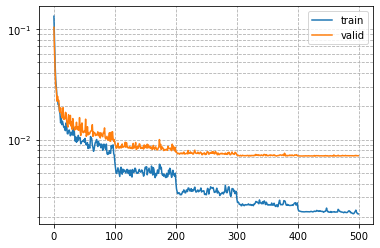

In [53]:
plt.figure(1)
loss_train = np.array(train_l2_rec)
loss_val = np.array(test_l2_rec)
plt.semilogy(loss_train, label='train')
plt.semilogy(loss_val, label='valid')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In [60]:
optimizer = torch.optim.AdamW(model.parameters(), lr=8e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=gamma)
epochs = 100
with tqdm(total=epochs) as pbar_ep:
                            
    for epoch in range(epochs):
        model.train()
        train_l2 = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)

            loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()
            
        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s, s)
                out = y_normalizer.decode(out)

                test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

        train_l2/= ntrain
        test_l2 /= ntest
        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2)
  
        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        desc += f"| train loss: {train_l2:.3e} "
        desc += f"| val loss: {test_l2:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

  0%|          | 0/100 [00:00<?, ?it/s]

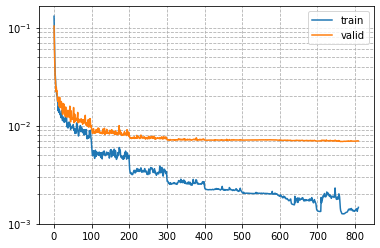

In [61]:
plt.figure(1)
loss_train = np.array(train_l2_rec)
loss_val = np.array(test_l2_rec)
plt.semilogy(loss_train, label='train')
plt.semilogy(loss_val, label='valid')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In [44]:
################################################################
# training and evaluation
################################################################
model = FNO2d(10, 10, 32).to(device)
print(count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
#                        div_factor=1e4, 
#                        final_div_factor=1e4,
#                        pct_start=0.3,
#                        steps_per_epoch=len(train_loader)*5, 
#                        epochs=100)


myloss = LpLoss(size_average=False)

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

with tqdm(total=epochs) as pbar_ep:
                            
    for epoch in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)
    #         y = y_normalizer.decode(y)

            loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()
            
        ############################
        lr = optimizer.param_groups[0]['lr']
        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        pbar_ep.set_description(desc)
        pbar_ep.update()

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s, s)
                out = y_normalizer.decode(out)

                test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

        train_l2/= ntrain
        test_l2 /= ntest

        t2 = default_timer()
        print(epoch, t2-t1, train_l2, test_l2)

1647105


  0%|          | 0/500 [00:00<?, ?it/s]

0 2.2000478971749544 0.16809501552581788 0.11760571479797363
1 2.184341622516513 0.10978863155841827 0.10487501382827759
2 2.184962471947074 0.08811287760734558 0.07563260436058045
3 2.1857729591429234 0.062457907021045686 0.05769967675209045
4 2.1864749528467655 0.04941212868690491 0.046010205149650575
5 2.189503660425544 0.043370871126651764 0.04414472758769989
6 2.1889094039797783 0.03647813540697098 0.03606738865375519
7 2.188121424987912 0.03103893059492111 0.03147760391235352
8 2.1905626580119133 0.028406385868787767 0.028912636041641234
9 2.1889375131577253 0.025635686844587325 0.03147736191749573
10 2.191672168672085 0.02593327847123146 0.026791725754737854
11 2.1907197646796703 0.02302770036458969 0.023858633637428284
12 2.1924042385071516 0.020490209013223647 0.023010475635528563
13 2.1918165925890207 0.02017829802632332 0.026213593184947967
14 2.1943672075867653 0.021745255082845687 0.0214003923535347
15 2.196720926091075 0.017981269150972368 0.024211947321891785
16 2.196348

In [27]:
epochs = 500
optimizer = Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
#                        div_factor=1e4, 
#                        final_div_factor=1e4,
#                        pct_start=0.3,
#                        steps_per_epoch=len(train_loader)*5, 
#                        epochs=100)


myloss = LpLoss(size_average=False)

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

with tqdm(total=epochs) as pbar_ep:
                            
    for epoch in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)
    #         y = y_normalizer.decode(y)

            loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()
            
        ############################
        lr = optimizer.param_groups[0]['lr']
        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        pbar_ep.set_description(desc)
        pbar_ep.update()

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s, s)
                out = y_normalizer.decode(out)

                test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

        train_l2/= ntrain
        test_l2 /= ntest

        t2 = default_timer()
        print(epoch, t2-t1, train_l2, test_l2)

  0%|          | 0/500 [00:00<?, ?it/s]

0 4.918366344645619 0.009056274086236953 0.008617604970932008
1 4.928460575640202 0.00500779564678669 0.008468602001667023
2 4.9300401750952005 0.004564413249492645 0.008360137343406676
3 4.9281385857611895 0.00450154996663332 0.008593452274799346
4 4.924270730465651 0.00499767529964447 0.009178255498409272
5 4.923990942537785 0.005724080041050911 0.008358342945575714
6 4.9266063664108515 0.005046013318002224 0.008514917194843293
7 4.925262816250324 0.004867603905498981 0.008198720663785934
8 4.920864265412092 0.005174784913659095 0.008254533857107163
9 4.913515890017152 0.004964656621217728 0.008644744008779525
10 4.9328363090753555 0.005462375804781914 0.00828424796462059
11 4.933052422478795 0.0048614168912172314 0.008169989734888077
12 4.933904567733407 0.005888080328702926 0.008661424219608306
13 4.93487804569304 0.005472562044858933 0.008625458329916
14 4.935931822285056 0.005552706815302372 0.008440094143152237
15 4.933305909857154 0.005103006221354007 0.008465375453233719
16 4.

In [41]:
epochs = 500
model = FNO2d(modes, modes, 40).to(device)
print(count_params(model))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
#                        div_factor=1e4, 
#                        final_div_factor=1e4,
#                        pct_start=0.3,
#                        steps_per_epoch=len(train_loader)*5, 
#                        epochs=100)


myloss = LpLoss(size_average=False)

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

with tqdm(total=epochs) as pbar_ep:
                            
    for epoch in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)
    #         y = y_normalizer.decode(y)

            loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()
            
        ############################
        lr = optimizer.param_groups[0]['lr']
        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        pbar_ep.set_description(desc)
        pbar_ep.update()

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s, s)
                out = y_normalizer.decode(out)

                test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

        train_l2/= ntrain
        test_l2 /= ntest

        t2 = default_timer()
        print(epoch, t2-t1, train_l2, test_l2)

3698497


  0%|          | 0/500 [00:00<?, ?it/s]

0 2.3923319783061743 0.16044498777389526 0.11486047267913818
1 2.384324660524726 0.10454395282268523 0.09674615979194641
2 2.382553832605481 0.0781529929637909 0.06425435423851013
3 2.383607428520918 0.05705444824695587 0.052716965675354006
4 2.3843337576836348 0.0441395748257637 0.04193912029266358
5 2.384529035538435 0.03443048536777496 0.03420851469039917
6 2.3851748313754797 0.030798122465610506 0.03239836692810059
7 2.385246280580759 0.026988554507493972 0.027737122774124146
8 2.3854966927319765 0.024463143557310104 0.02572058379650116
9 2.385958466678858 0.021732020765542984 0.026579384803771974
10 2.3858217149972916 0.02040632277727127 0.02472914069890976
11 2.386238956823945 0.020067536652088165 0.022696007192134857
12 2.3866615314036608 0.018655417203903197 0.022115610241889953
13 2.386169945821166 0.018462661921977996 0.021509369015693666
14 2.3866711165755987 0.018537365436553956 0.02128229081630707
15 2.3873448316007853 0.016727054864168166 0.021875238120555876
16 2.3900334

KeyboardInterrupt: 